In [1]:
import zarr
import numpy as np
#Loading Required Libraries 
import anndata
import scipy as sp
import geopandas
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import pandas as pd
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from splot.esda import plot_moran
import pyseq
from pyseq import image_analysis as ia
from dask.distributed import Client
import xarray as xr
import dask
%run /gpfs/commons/home/jsingh/util_pyseq.ipynb

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
!pwd

/gpfs/commons/home/jsingh


In [5]:
im = ia.get_HiSeqImages(image_path = 'zarrs/m387ntga2.zarr')

ImageAnalysis::Opened m387ntga2 


/gpfs/commons/home/jsingh/PySeq2500/pyseq/image_analysis.py:955: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  im = xr.open_zarr(fn).to_array()


In [6]:
im.im

<xarray.DataArray 'm387ntga2' (obj_step: 10, channel: 4, cycle: 4, row: 10467,
                               col: 10752)>
dask.array<getitem, shape=(10, 4, 4, 10467, 10752), dtype=int16, chunksize=(1, 1, 1, 10467, 1792), chunktype=numpy.ndarray>
Coordinates:
  * channel   (channel) int64 558 610 687 740
  * cycle     (cycle) int64 1 2 3 4
  * obj_step  (obj_step) int64 8028 8263 8498 8733 8968 ... 9438 9673 9908 10143
Dimensions without coordinates: row, col
Attributes:
    first_group:  0
    machine:      None
    scale:        1
    overlap:      256
    fixed_bg:     1

In [27]:
#The labels are basically the cells
#The one_z_plane are the pixel intensity for the different lables

In [7]:
import skimage

one_z_plane = im.im.sel(obj_step = 8498, channel = 610, cycle=1)
#gdf = geopandas.read_file('~/voronoi_regions/voronoi_regions.shp')
labels = skimage.io.imread('/gpfs/commons/groups/nygcfaculty/PySeq/20210428_mouse_genotype_2/segmented_sections/m387ntga2_labels.tiff')

 ...]

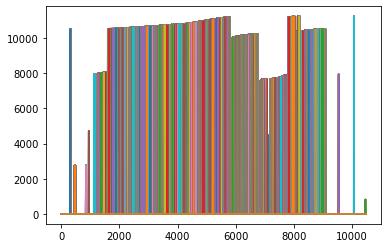

In [8]:
plt.plot(labels)

In [29]:
print(one_z_plane.shape)
print(labels.shape)

(10467, 10752)
(10467, 10752)


In [30]:
s = one_z_plane.data[labels == 112].mean()
s.compute()

648.1735537190083

In [31]:
persisted_plane = one_z_plane.persist()

In [32]:
persisted_plane

<xarray.DataArray 'm387ntga2' (row: 10467, col: 10752)>
dask.array<getitem, shape=(10467, 10752), dtype=int16, chunksize=(10467, 1792), chunktype=numpy.ndarray>
Coordinates:
    channel   int64 610
    cycle     int64 1
    obj_step  int64 8498
Dimensions without coordinates: row, col
Attributes:
    first_group:  0
    machine:      None
    scale:        1
    overlap:      256
    fixed_bg:     1

In [33]:
one_z_plane.values[labels == 112]

array([392, 379, 384, 376, 381, 389, 394, 384, 386, 388, 399, 408, 436,
       452, 375, 377, 386, 396, 399, 409, 414, 417, 435, 459, 474, 497,
       507, 386, 381, 393, 391, 395, 400, 415, 415, 433, 442, 471, 474,
       497, 504, 534, 533, 546, 404, 402, 382, 389, 398, 404, 408, 420,
       443, 456, 477, 488, 493, 511, 535, 556, 572, 582, 424, 417, 416,
       419, 414, 431, 433, 443, 466, 486, 500, 528, 521, 525, 548, 578,
       600, 615, 451, 437, 439, 447, 449, 457, 463, 475, 497, 511, 522,
       543, 538, 554, 586, 601, 612, 655, 496, 491, 473, 478, 472, 493,
       489, 502, 513, 534, 552, 560, 567, 575, 602, 624, 660, 693, 550,
       540, 514, 504, 508, 524, 535, 538, 535, 565, 585, 596, 596, 596,
       637, 658, 684, 709, 582, 561, 550, 537, 547, 557, 577, 584, 581,
       603, 621, 623, 619, 631, 666, 684, 699, 736, 635, 589, 571, 580,
       584, 594, 599, 620, 647, 651, 650, 643, 650, 662, 681, 720, 733,
       764, 652, 632, 618, 617, 620, 637, 653, 666, 659, 678, 67

In [12]:
!more /gpfs/commons/groups/nygcfaculty/PySeq/20210428_mouse_genotype_2/stains.cfg

[558]
1 = LMNB1
2 = LMNB1
3 = LMNB1
4 = LMNB1

[610]
1 = ELAVL2
2 = IBA1
3 = PVALB
4 = PDGFRA

[687]
1 = GFAP
2 = MAP2
3 = NFH
4 = MBP


In [34]:
max_labels = labels.max()
mean_stain = da.from_array(np.zeros(shape = (max_labels, 1)))

In [40]:
max_labels

11232

In [35]:
one_z_plane.data[113].mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [36]:
def get_pixels(lab,plane):
    m = one_z_plane.data[labels == lab+1].mean()
    return m

In [37]:
def get_pixels_persisted(lab,plane):
    m = plane.values[labels == lab+1].mean()
    return m

In [8]:
get_pixels = delayed(get_pixels)

In [38]:
s = get_pixels_persisted(lab = 23,plane = persisted_plane )

In [39]:
s

299.50847457627117

In [22]:
def t_pixels(lab,plane):
    m = one_z_plane.values[labels == lab+1].mean()
    return m
s = t_pixels(lab = 23,plane = one_z_plane)

In [22]:
results = []
for l in range(max_labels):
    y = get_pixels_persisted(lab = l+1,plane = persisted_plane)
    print(l)
    results.append(y)
    
    
    


NameError: name 'max_labels' is not defined

In [9]:
results = []
for l in range(max_labels):
    y = get_pixels(l+1,one_z_plane)
    results.append(y)
    

In [46]:
!squeue -u jsingh

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          22362878       pe2     bash   jsingh  R    1:36:05      1 pe2cc3-009


In [11]:
dask.compute(results, scheduler = 'threads')

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/dask/base.py:1346: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/tmp/ipykernel_21796/585221636.py:2: RuntimeWarning: Mean of empty slice.
  m = one_z_plane.values[labels == lab+1].mean()
/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
2022-06-15 12:05:14,190 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-15 12:05:14,193 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-15 12:05:14,194 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-15 12:05:14,194 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-15 12:05:14,194 - distributed.nanny - ERROR - Worker process died unexpectedly
Exception in

KeyboardInterrupt: 

2022-06-15 12:05:15,308 - distributed.nanny - WARNING - Restarting worker


In [39]:
results[0]

Delayed('get_pixels-aa41f7e8-d643-4bb5-afd6-2732d3192f0d')

In [10]:
#create dask client 
from dask.distributed import Client
client = Client(n_workers=8)
client

2022-06-15 12:00:20,801 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/commons/home/jsingh/dask-worker-space/worker-hdn5l0ra', purging
2022-06-15 12:00:20,807 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/commons/home/jsingh/dask-worker-space/worker-0sc1nfst', purging
2022-06-15 12:00:20,811 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/commons/home/jsingh/dask-worker-space/worker-mboo1npx', purging
2022-06-15 12:00:20,815 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/commons/home/jsingh/dask-worker-space/worker-upxlgzc_', purging
2022-06-15 12:00:20,818 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/commons/home/jsingh/dask-worker-space/worker-vrun2enb', purging
2022-06-15 12:00:20,824 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/commons/home/jsingh/dask-worker-space/worker-7bx0swp2', purging
2022-06-15 12:00

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37883,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:45644,Total threads: 2
Dashboard: http://127.0.0.1:33011/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:34799,


In [14]:
#### USING SLURM CLUSTER
#dask.config.set({'temporary-directory': '/scratch'})
def get_cluster(queue_name = 'pe2', log_dir=None):
    """ Make dask cluster w/ workers = 2 cores, 32 G mem, and 1 hr wall time.

        return cluster, client
    """

    if log_dir is None:
        log_dir = join(getcwd(),'dask_logs')
        makedirs(log_dir, exist_ok=True)

    cluster = SLURMCluster(
                queue = queue_name,
                cores = 2,
                memory = '32G',
                walltime='1:00:00',
                log_directory=log_dir,
                extra=["--lifetime", "55m", "--lifetime-stagger", "4m"])
    client = Client(cluster)

    return cluster, client

cluster, client = get_cluster()
print(cluster.dashboard_link)

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39964 instead
  warnings.warn(


AttributeError: 'function' object has no attribute 'dashboard_link'

In [19]:
client.scale(10)

In [47]:
client.restart()

AttributeError: 'SLURMCluster' object has no attribute 'restart'

In [ ]:
for r in results:
    x = delayed(r.compute())

In [ ]:
len(results)

In [ ]:
y.compute()

In [ ]:
max_labels = labels.max()
mean_stain = da.from_array(np.zeros(shape = (max_labels, 1)))
for l in range(max_labels):
    mean_stain[l] = delayed(one_z_plane.data[labels == l+1].mean())

In [ ]:
mean_stain[l]

In [ ]:
l = 5
one_z_plane.data[labels == 5]

In [ ]:
client.restart()

In [ ]:
#random section
za = im.im
ar = za.sel(channel=610, cycle=1, obj_step = 8028)a

In [ ]:
ar.shape

In [ ]:
import matplotlib.pyplot as plt
za.plot
plt.savefig("df")

In [ ]:
plt.plot(za)

In [ ]:
#loading ploygon regions 
gdf = geopandas.read_file('~/voronoi_regions/voronoi_regions.shp')
poly_list = gdf.geometry

In [ ]:
#create dask client 
from dask.distributed import Client
client = Client(n_workers=4)
client

In [ ]:
#coordinate list
def create_list(x):
    cr_list = []
    for i in range(10467):
        for j in range(10752):
            cr_list.append([i,j])
    return cr_list

In [ ]:
cr_arr = [0,0]
cr_arr = np.vstack((cr_arr,[1,2]))
cr_arr = np.vstack((cr_arr,[1,2]))

In [ ]:
cr_arr

In [ ]:
np.shape(cr_arr)

In [ ]:
cr_arr = [0,0]
cr_arr = np.append([cr_arr], [[1,2]], axis = 0)

In [ ]:
cr_arr = np.vstack(cr_arr,[1,4])

In [ ]:
cr_arr

In [ ]:
np.shape(cr_arr)

In [ ]:
@dask.delayed
def create_lt(x):
    cr_arr = [0,0]
    for j in range(10467):
        cr_arr = np.vstack((cr_arr,[x,j]))
                
    return cr_arr
        

In [ ]:
td_list = []
for x in range(10467):
    delayed(td_list.append(create_lt(x)))
    


In [ ]:
z = create_lt(1)
z.compute()

In [ ]:
z = create_lt(1)
v = create_lt(2)

In [ ]:
q = z.compute()
w = v.compute()

In [ ]:
xr.DataArray(q)

In [ ]:
xr.DataArray(q).stack(dim xr.DataArray(w), create_index = False)

In [ ]:
xr.concat([xr.DataArray(q),xr.DataArray(w)], dim = "dim_0")

In [ ]:
q = q.append(w)

In [ ]:
arr = xr.DataArray(
    np.arange(6).reshape(2, 3),
    coords=[("x", ["a", "b"]), ("y", [0, 1, 2])],
)
arr
stacked = arr.stack(z=("x", "y"))
stacked.indexes["z"]

In [ ]:
stacked

In [ ]:
td_list = []
for x in range(10467):
    delayed(td_list.append(create_lt(x)))
    


In [ ]:
z = dask.compute(td_list)

In [ ]:
z

In [ ]:
z.compute()

In [ ]:
import dask
create_list = dask.delayed(create_list)

In [ ]:
z = create_list(2)

In [ ]:
z.visualize()

In [ ]:
#reading attributes##
!ls

In [ ]:
pwd

In [ ]:
##### Loading zmax2 files #####


/groups/nygcfaculty/PySeq/20210428_mouse_genotype_2/zmax2/m387ntgb3_zmax.attrs





